In [16]:
import os
import torch
import random
import numpy as np

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

import cv2
from PIL import Image
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [17]:
data_dir = '/home/krishnatejaswis/Files/VSCode/IntelliArtGen/data/training_set/iconography'


image_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
batch_size = 32
    
latent_size = 128
clip_value = 0.01
n_critic = 5

In [18]:
def get_image(img_path):
    img_bgr = cv2.imread(img_path)
    img_rgb = img_bgr[:,:,::-1]
    return img_rgb

def plot_images(n_imgs, data_fold = data_dir):
    fnames = random.sample(os.listdir(data_fold), n_imgs)
    
    size = np.sqrt(n_imgs)
    if int(size)*int(size) < n_imgs:
        size = int(size) + 1
    
    plt.figure(figsize = (10, 10))
    
    for ind in range(n_imgs):
        plt.subplot(size, size, ind+1)
        img = get_image(os.path.join(data_fold, fnames[ind]))
        
        plt.imshow(img)
        plt.axis('off')
    plt.show()

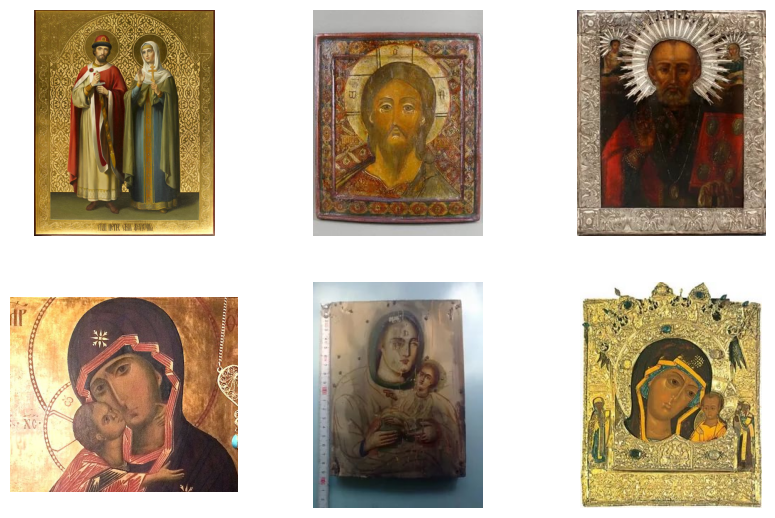

In [19]:
plot_images(6, data_dir)

In [20]:
# Creating a Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, fold_path, transforms):
        super().__init__()
        self.fold_path = fold_path
        self.transforms = transforms
        self.img_names = os.listdir(fold_path)
        
    def __len__(self):
        return len(self.img_names)
        
    def __getitem__(self, idx):
        img_path = self.fold_path + '/' + self.img_names[idx]
        
        try:
            img = Image.open(img_path)
            img = self.transforms(img)        
            return img, 0
        except:
            return None

# Dont load invalid or corrupt images
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [21]:
# Here I am normalizing the Image between [-1,1]. #GAN Hack
transforms = T.Compose([
                T.Resize(image_size),
                T.CenterCrop(image_size),
                T.RandomHorizontalFlip(p=0.5),
                T.ToTensor(),
                T.Normalize(*stats)
            ])

In [22]:
train_ds = CustomDataset(data_dir, transforms)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory = True, collate_fn=collate_fn)

In [23]:
# Utility functions to show images from data loader
def denormalize(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images[:nmax]).cpu().detach(), nrow=8).permute(1,2,0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

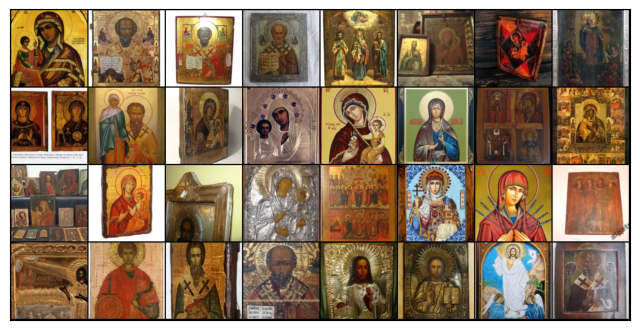

In [24]:
show_batch(train_dl, nmax=64)

In [25]:
# Wrappers to move data into memory
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
# Weights Initialization

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [28]:
# Discriminator Model for 128x128 px images

discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out : 256 x 16 x 16
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out : 512 x 8 x 8
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4
    
    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten()
)

In [29]:

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    # Out: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    # out: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [30]:
# Initialize weights
discriminator.apply(weights_init)
generator.apply(weights_init);

In [31]:
# Use GPU if available
train_dl = DeviceDataLoader(train_dl, device)
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [32]:
# Utility function to save generated images while training
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalize(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    
    if show:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]), ax.set_yticks([]);
        ax.imshow(make_grid(denormalize(fake_images).cpu().detach(), nrow=8).permute(1,2,0))

In [33]:
# WGAN Training Method

def fit(epochs, lr_d, lr_g, print_after=1, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr_d)
    opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr_g)
    
    for epoch in range(epochs):
        for images, _ in (train_dl):
            
            # Train Discriminator (Critic):  max E[critic(real)] - E[critic(fake)]
            for _ in range(n_critic):
                latent_noise = torch.randn(images.size(0), latent_size, 1, 1, device=device)
                fake_imgs = generator(latent_noise)
                
                preds_real_imgs = discriminator(images)
                preds_fake_imgs = discriminator(fake_imgs)
                
                loss_critic = -(torch.mean(preds_real_imgs) - torch.mean(preds_fake_imgs))
                opt_d.zero_grad()
                loss_critic.backward()
                opt_d.step()
                
                # Clip the Weights
                for par in discriminator.parameters():
                    par.data.clamp_(-clip_value, clip_value)
            
            # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
            latent_noise = torch.randn(images.size(0), latent_size, 1, 1, device=device)
            fake_imgs = generator(latent_noise) 
            
            loss_gen = -torch.mean(discriminator(fake_imgs))
            opt_g.zero_grad()
            loss_gen.backward()
            opt_g.step()
        
        # Record losses
        losses_g.append(loss_gen.item())
        losses_d.append(loss_critic.item())
        
        if (epoch+1)%print_after == 0:
            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
                   epoch+1, epochs, loss_gen.item(), loss_critic.item()))

            # Save generated images
            save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d

In [34]:
# Create a folder to save generated images
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [35]:
#  Use a fixed set of input vectors to see how the individual generated images evolve over time
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


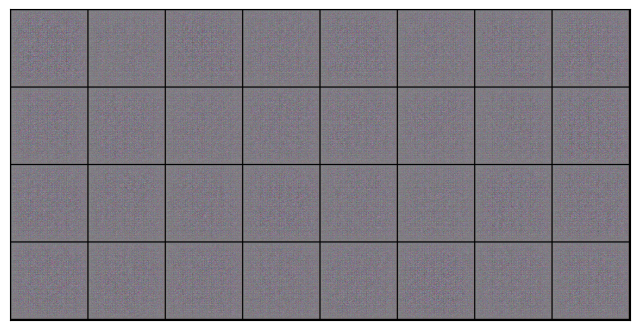

In [36]:
# Save a generated image before training
save_samples(0, fixed_latent)

In [48]:
lr_d = 0.0001
lr_g = 0.0001
epochs = 10

history = fit(epochs, lr_d, lr_g, print_after=1, start_idx=1)

Epoch [1/10], loss_g: 1.4897, loss_d: -3.0444
Saving generated-images-0001.png
Epoch [2/10], loss_g: 1.4967, loss_d: -3.0738
Saving generated-images-0002.png
Epoch [3/10], loss_g: 1.5012, loss_d: -3.0915
Saving generated-images-0003.png
Epoch [4/10], loss_g: 1.5082, loss_d: -3.1055
Saving generated-images-0004.png
Epoch [5/10], loss_g: 1.5030, loss_d: -3.0905
Saving generated-images-0005.png
Epoch [6/10], loss_g: 1.5033, loss_d: -3.0963
Saving generated-images-0006.png
Epoch [7/10], loss_g: 1.5024, loss_d: -3.0958
Saving generated-images-0007.png
Epoch [8/10], loss_g: 1.5048, loss_d: -3.0971
Saving generated-images-0008.png
Epoch [9/10], loss_g: 1.5047, loss_d: -3.0925
Saving generated-images-0009.png
Epoch [10/10], loss_g: 1.5057, loss_d: -3.0988
Saving generated-images-0010.png


In [44]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Generator.pth')
torch.save(discriminator.state_dict(), 'Discriminator.pth')

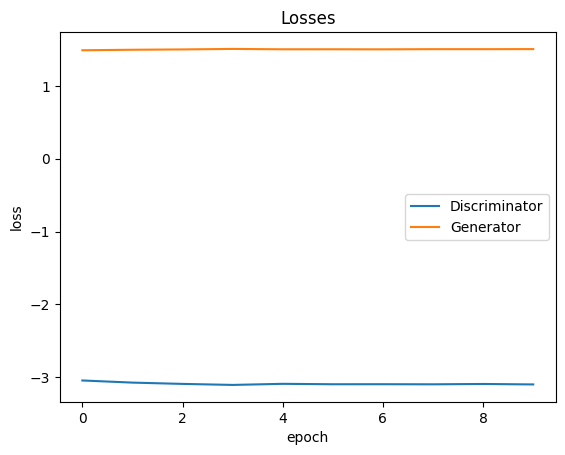

In [49]:
# Plot Figures
losses_g, losses_d = history

plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.savefig("output", bbox_inches="tight");

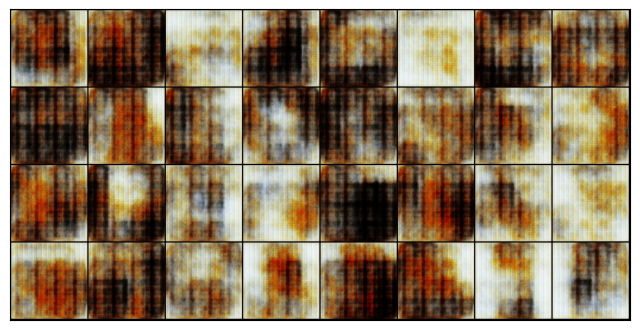

In [50]:
# Generate images after training
xb = torch.randn(32, latent_size, 1, 1, device=device)
fake_images = generator(xb)
show_images(fake_images)

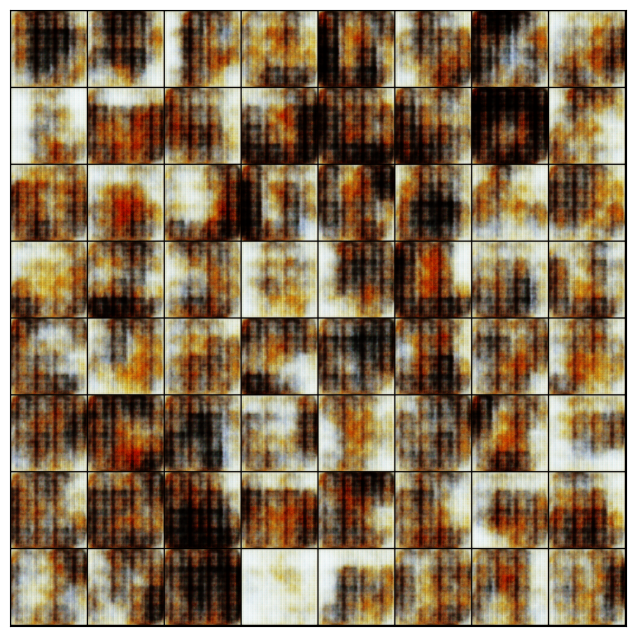

In [51]:
# Generate images after training
xb = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = generator(xb)
show_images(fake_images)

In [ ]:
# Convert the images into a Video
vid_fname = 'gans_training_1000.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

frame_array = []
for i in range(len(files)):
    filename= files[i]
    img = cv2.imread(filename) # reading each files
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img) # inserting the frames into an image array

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()